# Notebook for Historical Performance-Weighted Strategy

This notebook presents a trading strategy that integrates historical asset performance into the trading decision-making process. By analyzing past returns within identified market states, we assign portfolio weights based on stocks' relative performance in similar conditions. This approach aims to enhance risk-adjusted returns by favoring assets that have consistently performed well in corresponding market regimes. 

Let's start by importing the necessary libraries. Key libraries include :
- `matplotlib`: For creating clear graphs that will be used to analyze the results.
- `numpy` and `pandas`: For numerical calculations and efficient DataFrame manipulations.
- `pickle`: For serializing and de-serializing a Python object structure.

In [ ]:
# Import necessary libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle

We start by loading the required datasets. First the log return matrix containning the 5-minute log returns for each ticker, which serves as the foundation for implementing the strategy. Then, the clustering results containning the segmentation of 5-minute windows into distinct market states, which we will use for analysis.

In [ ]:
# Load the log-return matrix
log_return_matrix = pd.read_csv('log_return_matrix.csv')

# Load the clustering results
with open('clustering_results.pkl', 'rb') as file:
    clustering_results = pickle.load(file)

In this sophisticated approach, we assign dynamic weights to stocks within each market state. The key components of this strategy are :
1) Historical Performance Weights : Each stock is weighted based on its average log-returns within the same market state.
2) Dynamic Portfolio Allocation : Weights are normalized to maintain diversification while emphasizing high-performing stocks.
3) Market Neutrality : Ensures the portfolio is balanced by adjusting weights dynamically.

In [ ]:
def third_strategy(clustering_results, matrix, measure='average'):
    """
    Implement the Historical Performance-Weighted Strategy.
    
    Parameters:
    - clustering_results (list of dict): Clustering results from sliding window analysis.
    - matrix (pd.DataFrame): Log-return matrix with timestamps and stock returns.
    - measure (str): Performance measure ('average', 'median').
    
    Returns:
    - strategy_results (list of dict): Contains portfolio weights for each window.
    """
    strategy_results = []

    for result in clustering_results:
        # Extract clustering data for the current window
        clusters_df = result['clusters_df']
        start_time = result['start_time']
        end_time = result['end_time']
        
        # Identify the market state at the last timestamp
        last_timestamp = clusters_df['Timestamp'].iloc[-1]
        market_state = clusters_df.loc[clusters_df['Timestamp'] == last_timestamp, 'Cluster'].values[0]
        
        # Find prior timestamps within the same market state
        previous_states = clusters_df[(clusters_df['Timestamp'] < last_timestamp) & 
                                      (clusters_df['Cluster'] == market_state)]
        previous_indices = matrix[matrix['timestamp_5min'].isin(previous_states['Timestamp'])].index
        
        if not previous_indices.empty:
            # Compute future indices for performance evaluation
            future_indices = previous_indices + 1
            future_indices = future_indices[future_indices < len(matrix)]
            
            # Calculate weights based on historical performance
            if measure == 'average':
                weights = matrix.iloc[future_indices, 1:].mean(axis=0)
            elif measure == 'median':
                weights = matrix.iloc[future_indices, 1:].median(axis=0)
            else:
                raise ValueError("Invalid performance measure")
            
            # Normalize weights to ensure balanced allocation
            weights = weights / weights.abs().sum()  # Market-neutral weights
        else:
            # Assign zero weights if no prior states exist
            weights = pd.Series(0, index=matrix.columns[1:])  # No signal if no prior states
        
        # Store results
        strategy_results.append({
            'start_time': start_time,
            'end_time': end_time,
            'market_state': market_state,
            'weights': weights.to_dict()
        })
    
    return strategy_results

Now, we apply the strategy to the log-return matrix and clustering results to derive actionable portfolio directions for each window.

In [ ]:
# Ensure timestamps are in UTC
log_return_matrix['timestamp_5min'] = pd.to_datetime(log_return_matrix['timestamp_5min'], utc=True)

# Apply the strategy
strategy_results = third_strategy(clustering_results, log_return_matrix, measure='average')

We now compare the strategy's performance against the buy-and-hold portfolio. Performace metrics include : 
- Cumulative Returns : Measures total portfolio growth.
- Sharpe Ratio : Assesses risk-adjusted returns.
- Volatility : Analyzes portfolio stability.

In [ ]:
def evaluate_third_strategy(strategy_results, matrix):
    """
    Evaluate the performance of the strategy and compare it to the buy-and-hold portfolio.

    Parameters:
    - strategy_results (list of dict): Output from the single_market_state_strategy function.
    - matrix (pd.DataFrame): The log-return matrix with a 'timestamp' column and stock returns as other columns.

    Returns:
    - returns_df (pd.DataFrame): A DataFrame containing strategy, and buy-and-hold returns for each time period.
    - metrics (dict): A dictionary with cumulative returns, Sharpe ratio, and volatility for the strategy, and buy-and-hold portfolio.
    """
    matrix['timestamp_5min'] = pd.to_datetime(matrix['timestamp_5min'])  # Ensure timestamp is datetime
    
    portfolio_returns = []
    buy_and_hold_returns = []
    timestamps = []

    for res in strategy_results:
        # Get the next period's returns
        end_time = res['end_time']
        weights = pd.Series(res['weights'])
        
        # Find the next row in the log-return matrix
        next_period = matrix[matrix['timestamp_5min'] > end_time].iloc[0] if (matrix['timestamp_5min'] > end_time).any() else None
        if next_period is None:
            break  # No future data available

        # Calculate asset returns and portfolio return
        asset_returns = next_period[1:]
        portfolio_return = (weights * asset_returns).sum()  # Weighted portfolio return
        portfolio_returns.append(portfolio_return)

        # Calculate buy-and-hold return (equal-weighted average)
        buy_and_hold_return = asset_returns.mean()
        buy_and_hold_returns.append(buy_and_hold_return)

        # Save the timestamp of the next period
        timestamps.append(next_period['timestamp_5min'])

    # Create DataFrame for returns
    returns_df = pd.DataFrame({
        'timestamp': timestamps,
        'portfolio': portfolio_returns,
        'buy_and_hold': buy_and_hold_returns
    })

    # Calculate performance metrics
    cumulative_portfolio = (1 + returns_df['portfolio']).prod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).prod() - 1
    sharpe_portfolio = returns_df['portfolio'].mean() / returns_df['portfolio'].std()
    sharpe_buy_and_hold = returns_df['buy_and_hold'].mean() / returns_df['buy_and_hold'].std()
    volatility_portfolio = returns_df['portfolio'].std()
    volatility_buy_and_hold = returns_df['buy_and_hold'].std()

    metrics = {
        'cumulative_portfolio': cumulative_portfolio,
        'cumulative_buy_and_hold': cumulative_buy_and_hold,
        'sharpe_portfolio': sharpe_portfolio,
        'sharpe_buy_and_hold': sharpe_buy_and_hold,
        'volatility_portfolio': volatility_portfolio,
        'volatility_buy_and_hold': volatility_buy_and_hold
    }
    
    return returns_df, metrics

Let's assess the performance of the strategy at both individual and cumulative levels.

In [ ]:
# Evaluate the strategy
returns_df, metrics = evaluate_third_strategy(strategy_results, log_return_matrix)

In [102]:
# Display metrics
print(f"Portfolio Cumulative Return : {metrics['cumulative_portfolio']:.2%}")
print(f"Buy and Hold Cumulative Return : {metrics['cumulative_buy_and_hold']:.2%}")

print(f"\nPortfolio Sharpe Ratio : {metrics['sharpe_portfolio']:.2f}")
print(f"Buy and Hold Sharpe Ratio : {metrics['sharpe_buy_and_hold']:.2f}")

print(f"\nPortfolio Volatility : {metrics['volatility_portfolio']:.3f}")
print(f"Buy and Hold Volatility : {metrics['volatility_buy_and_hold']:.3f}")

Portfolio Cumulative Return : 2.16%
Buy and Hold Cumulative Return : -0.46%

Portfolio Sharpe Ratio : 0.07
Buy and Hold Sharpe Ratio : -0.02

Portfolio Volatility : 0.002
Buy and Hold Volatility : 0.001


The plot below compares the cumulative returns of the strategy to the buy and hold portfolio over time.

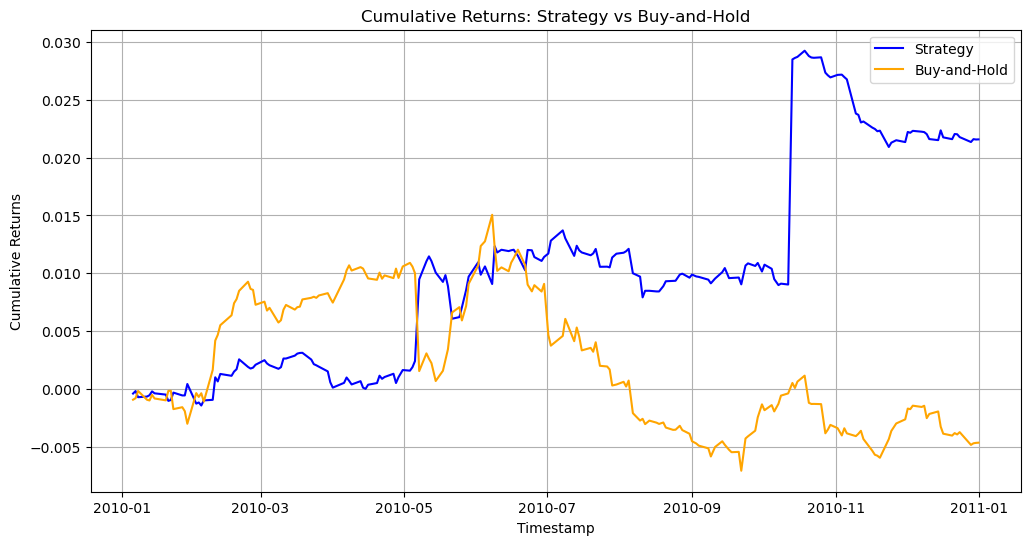

In [105]:
def plot_third_strategy(returns_df):
    """
    Plot cumulative returns for the strategy, and buy-and-hold portfolio.

    Parameters:
    - returns_df (pd.DataFrame): DataFrame with strategy, and buy-and-hold returns.
    """
    # Compute cumulative returns
    cumulative_portfolio = (1 + returns_df['portfolio']).cumprod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).cumprod() - 1

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(returns_df['timestamp'], cumulative_portfolio, label="Strategy", color='blue')
    plt.plot(returns_df['timestamp'], cumulative_buy_and_hold, label="Buy-and-Hold", color='orange')
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Returns: Strategy vs Buy-and-Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_third_strategy(returns_df)

The Historical Performance-Weighted Strategy achieves a compromise between consistent performance and profitability. While it delivers better results than the baseline approach, it does not match the growth potential demonstrated by the momentum-based strategy.